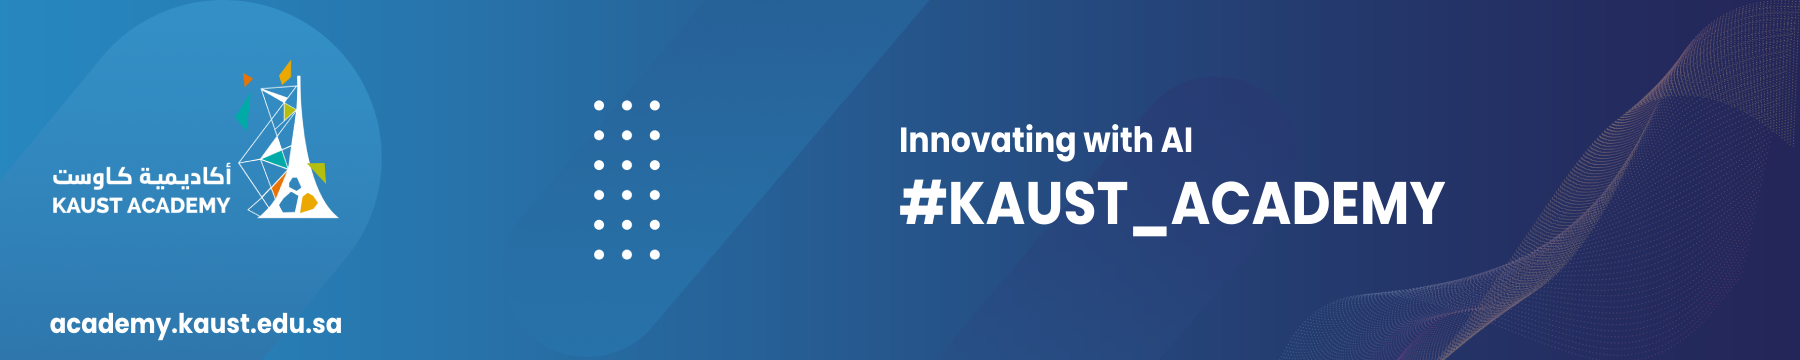

This notebook has been inspired from [PPO](https://github.com/nikhilbarhate99/PPO-PyTorch) by Nikhil Barhate, [pytorch_ppo_lunarlander_v2](https://github.com/lucaslingle/pytorch_ppo_lunarlander_v2/tree/main) by Lucas Lingle and [PPO OpenAI SpinningUp](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

# PPO

In this notebook, we will implementa basic PPO Reinforcement learning algorithm for Lunar Lander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![Cartpole](https://gymnasium.farama.org/_images/lunar_lander.gif)

## PPO

PPO is motivated by the same question as TRPO: how can we take the biggest possible improvement step on a policy using the data we currently have, without stepping so far that we accidentally cause performance collapse? Where TRPO tries to solve this problem with a complex second-order method, PPO is a family of first-order methods that use a few other tricks to keep new policies close to old. PPO methods are significantly simpler to implement, and empirically seem to perform at least as well as TRPO.

There are two primary variants of PPO: PPO-Penalty and PPO-Clip.

**PPO-Penalty** approximately solves a KL-constrained update like TRPO, but penalizes the KL-divergence in the objective function instead of making it a hard constraint, and automatically adjusts the penalty coefficient over the course of training so that it's scaled appropriately.

**PPO-Clip** doesn't have a KL-divergence term in the objective and doesn’t have a constraint at all. Instead relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.

Read more [here](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

Here, we'll focus only on PPO-Clip.

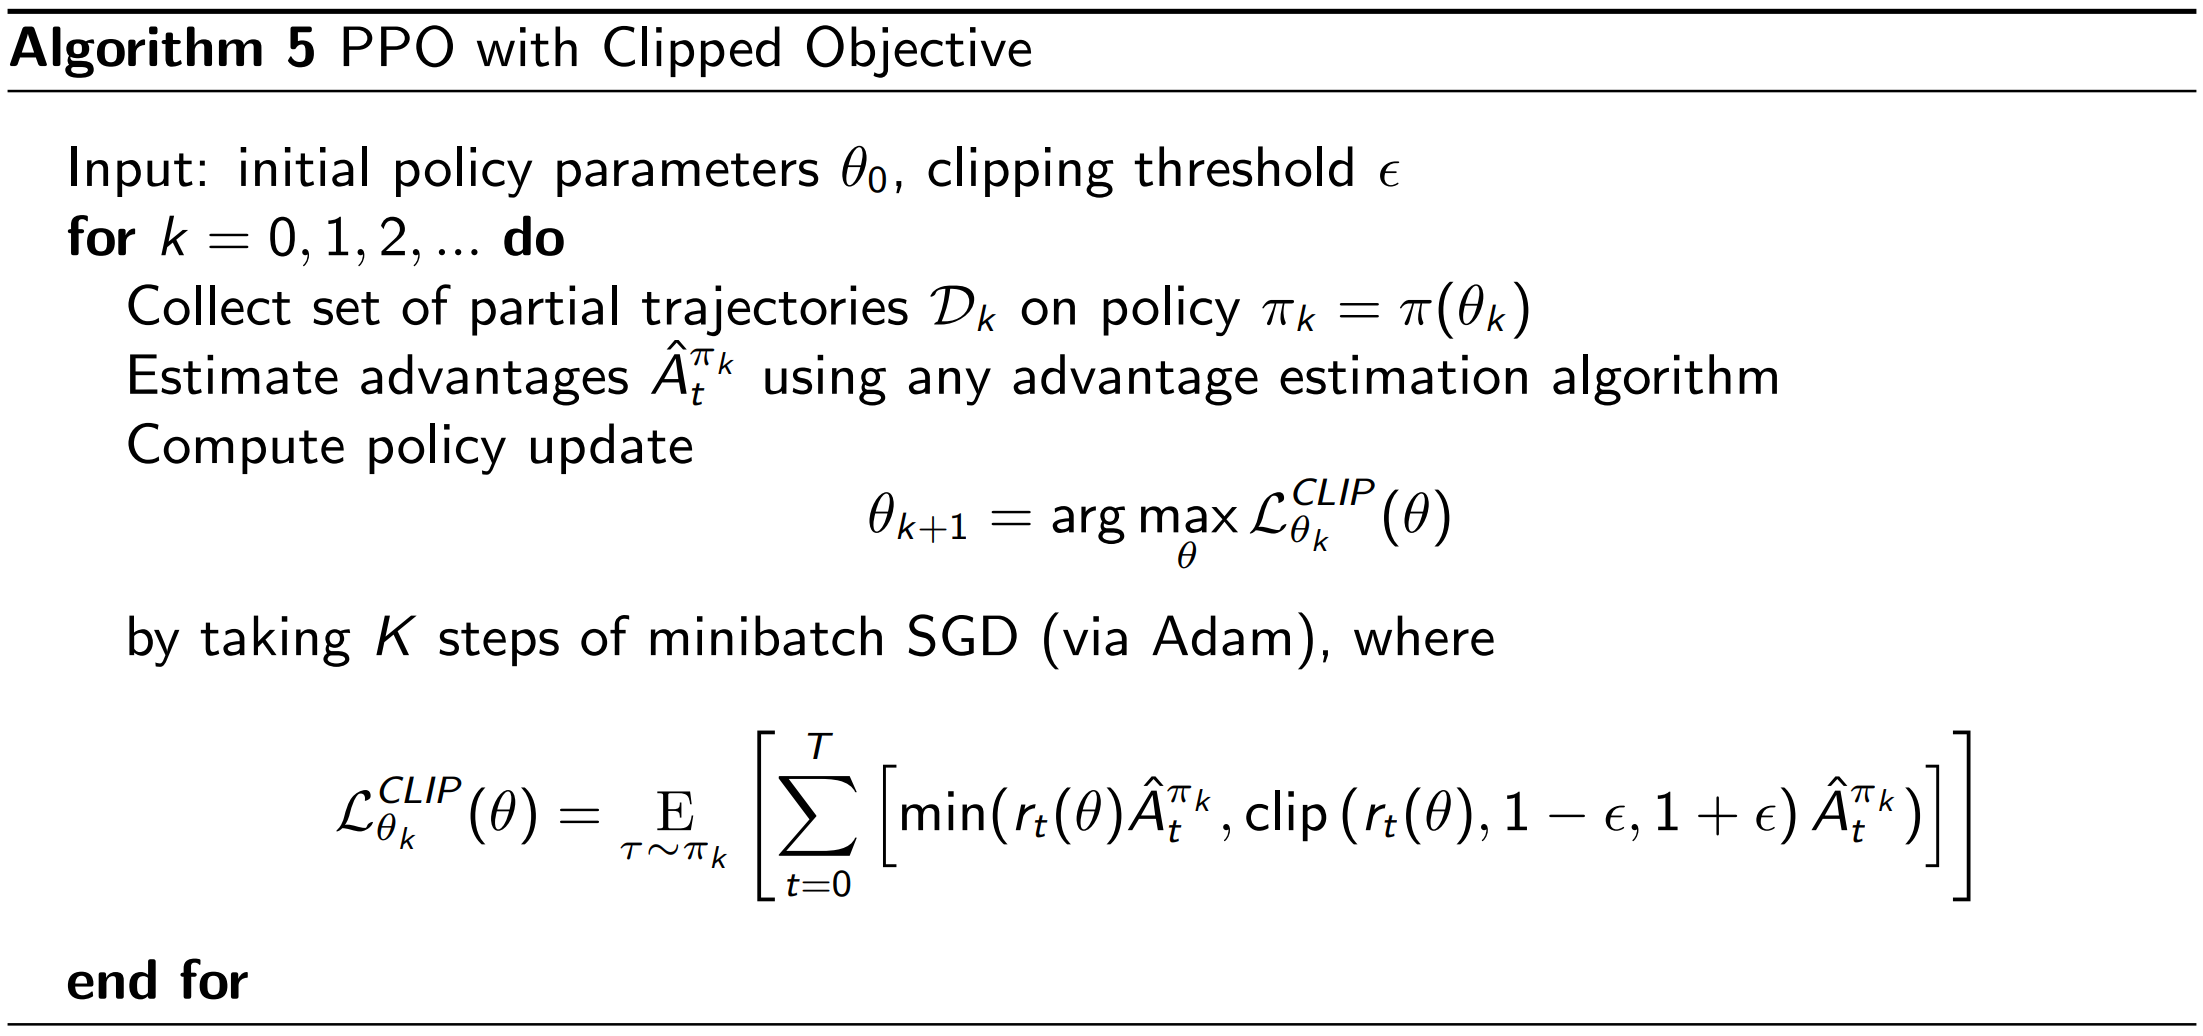

[Image Source](http://rail.eecs.berkeley.edu/deeprlcourse-fa17/)

In [ ]:
%pip install swig
%pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379417 sha256=0ef6c2386a986b6b7e5e17589385c6e9de4293e635851ebc3d1c94227875186f
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")

### Rollout Buffer

In [ ]:
# Buffer to store trajectories
class RolloutBuffer:
  def __init__(self):
    self.actions = []
    self.states = []
    self.logprobs = []
    self.rewards = []
    self.state_values = []
    self.is_terminals = []

  def clear(self):
    del self.actions[:]
    del self.states[:]
    del self.logprobs[:]
    del self.rewards[:]
    del self.state_values[:]
    del self.is_terminals[:]

### PPO Network

In [ ]:
class PPO(nn.Module):
    """
    PPO is an actor critic method. Here we will implement both actor and critic in one model
    """
    def __init__(self, n_observations, n_actions):
      super(PPO, self).__init__()
      self.affine1 = nn.Linear(n_observations, 128)

      # actor's layer
      self.action_head = nn.Linear(128, n_actions)

      # critic's layer
      self.value_head = nn.Linear(128, 1)

    def forward(self, x):
      """
      forward of both actor and critic
      """
      x = F.relu(self.affine1(x))

      # actor: choses action to take from state s_t
      # by returning probability of each action
      action_prob = F.softmax(self.action_head(x), dim=-1)

      # critic: evaluates being in the state s_t
      state_values = self.value_head(x)

      # return values for both actor and critic as a tuple of 2 values:
      # 1. a list with the probability of each action over the action space
      # 2. the value from state s_t
      return action_prob, state_values

    def act(self, state):
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      with torch.no_grad():
        probs, state_value = self.forward(state)
      # create a categorical distribution over the list of probabilities of actions
      m = Categorical(probs)
      # and sample an action using the distribution
      action = m.sample()
      return action, m.log_prob(action), state_value.squeeze(0)

    def evaluate(self, state, action):
      """
      Evaluate state action according to current policy
      """
      probs, state_value = self.forward(state)
      m = Categorical(probs)

      action_logprobs = m.log_prob(action)
      dist_entropy = m.entropy()

      return action_logprobs, state_value, dist_entropy

### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 1000        # Total training episodes
max_steps = 500              # Max steps per episode
learning_rate = 1e-3         # Learning rate
gamma = 0.99                 # Discounting rate
train_freq = 5               # update policy every n timesteps
K_epochs = 10                # update policy for K epochs
eps_clip = 0.2               # clip parameter for PPO

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [ ]:
# Intialize policy network
agent = PPO(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

In [ ]:
scores = []
buffer = RolloutBuffer()
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state, _ = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = agent.act(state)
    state, reward, terminated, truncated, _ = env.step(action.item())
    done = terminated or truncated

    # Saving in buffer
    buffer.states.append(torch.FloatTensor(state).to(device))
    buffer.actions.append(action)
    buffer.logprobs.append(log_prob)
    buffer.state_values.append(value)
    buffer.rewards.append(reward)
    buffer.is_terminals.append(done)

    rewards.append(reward)

    if done:
        break

  scores.append(sum(rewards))

  if episode % train_freq == 0:
    # Compute the discounted returns at each timestep
    returns = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(buffer.rewards), reversed(buffer.is_terminals)):
      if is_terminal:
        discounted_reward = 0
      discounted_reward = reward + (gamma * discounted_reward)
      returns.insert(0, discounted_reward)

    # Normalizing the returns
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-7)

    # convert list to tensor
    old_states = torch.squeeze(torch.stack(buffer.states, dim=0)).detach().to(device)
    old_actions = torch.squeeze(torch.stack(buffer.actions, dim=0)).detach().to(device)
    old_logprobs = torch.squeeze(torch.stack(buffer.logprobs, dim=0)).detach().to(device)
    old_state_values = torch.squeeze(torch.stack(buffer.state_values, dim=0)).detach().to(device)

    # calculate advantages
    advantages = returns.detach() - old_state_values.detach()

    # Optimize policy for K epochs
    for _ in range(K_epochs):
      # Evaluating old actions and values
      logprobs, state_values, dist_entropy = agent.evaluate(old_states, old_actions)

      # match state_values tensor dimensions with returns tensor
      state_values = torch.squeeze(state_values)

      # Finding the ratio (pi_theta / pi_theta__old)
      ratios = torch.exp(logprobs - old_logprobs.detach())

      # Finding Surrogate Loss
      surr1 = ratios * advantages
      surr2 = torch.clamp(ratios, 1-eps_clip, 1+eps_clip) * advantages

      # final loss of clipped objective PPO
      loss = -torch.min(surr1, surr2) + 0.5 * F.smooth_l1_loss(state_values, returns) - 0.01 * dist_entropy

      # take gradient step
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()


    # clear buffer
    buffer.clear()


  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = -213.22352392795415
Episode 2: Reward = -433.4960688975047
Episode 3: Reward = -201.37933175128623
Episode 4: Reward = -339.7055528563591
Episode 5: Reward = -69.05971546138468
Episode 6: Reward = -260.99580590792687
Episode 7: Reward = -243.66064355403802
Episode 8: Reward = -118.49241032765029
Episode 9: Reward = -97.83595429373787
Episode 10: Reward = -257.40383864473813
Episode 11: Reward = -48.05716235185601
Episode 12: Reward = -143.9590274397595
Episode 13: Reward = -72.28994364520362
Episode 14: Reward = -233.46604697864746
Episode 15: Reward = -106.37931258257987
Episode 16: Reward = -59.76931619070848
Episode 17: Reward = -242.89742804476776
Episode 18: Reward = -37.192121690114845
Episode 19: Reward = -323.0560985705059
Episode 20: Reward = -284.87063831311207
Episode 21: Reward = -54.93506973512967
Episode 22: Reward = -115.24538763108447
Episode 23: Reward = -461.1497662785404
Episode 24: Reward = -168.64068815983933
Episode 25: Reward = -139.8339706090

Text(0, 0.5, 'Reward')

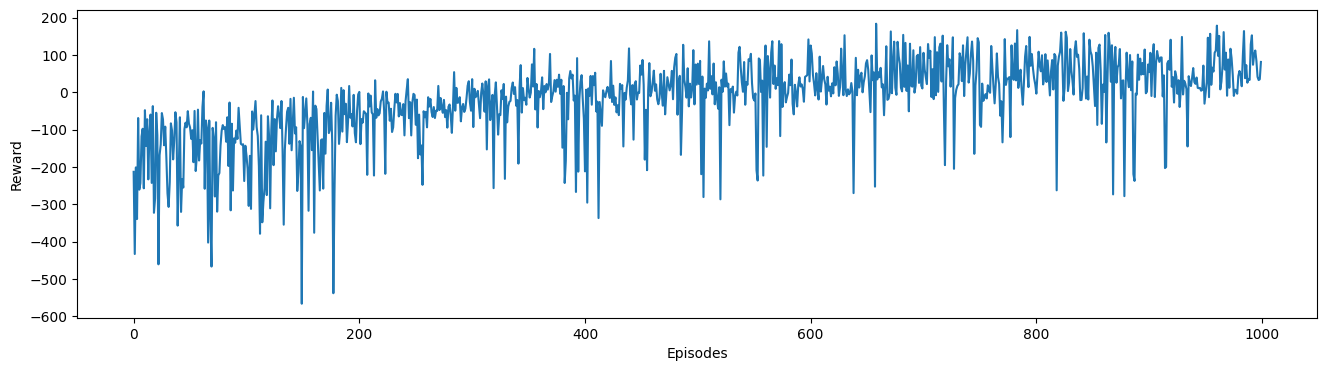

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state, _ = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _, _ = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("LunarLander-v3")

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
show_video("LunarLander-v3")